In [2]:
from src.fibonacci_optimizer import FibonacciOptimizer
from src.fibonacci_helper import FibonacciHelper
import matplotlib.pyplot as plt
import numpy as np

In [3]:
nside = 8192
patch_size = 10
save_dir = '/lustre/work/akira.tokiwa/Projects/LensingSSC/plot/setting/'
radius = np.radians(patch_size) * np.sqrt(2)

In [4]:
N=273
points = FibonacciHelper.fibonacci_grid_on_sphere(N)

In [5]:
mask_northpole = points[:, 0] <= radius
mask_southpole = points[:, 0] >= np.pi - radius
mask_equator0 = np.sqrt((points[:, 0] - np.pi/2)**2 + points[:, 1]**2) <= radius/2
mask_equator1 = np.sqrt((points[:, 0] - np.pi/2)**2 + (points[:, 1]-np.pi/2)**2) <= radius/2
mask_equator2 = np.sqrt((points[:, 0] - np.pi/2)**2 + (points[:, 1]-np.pi)**2) <= radius/2
mask_equator3 = np.sqrt((points[:, 0] - np.pi/2)**2 + (points[:, 1]-3*np.pi/2)**2) <= radius/2
mask = mask_northpole | mask_southpole | mask_equator0 | mask_equator1 | mask_equator2 | mask_equator3

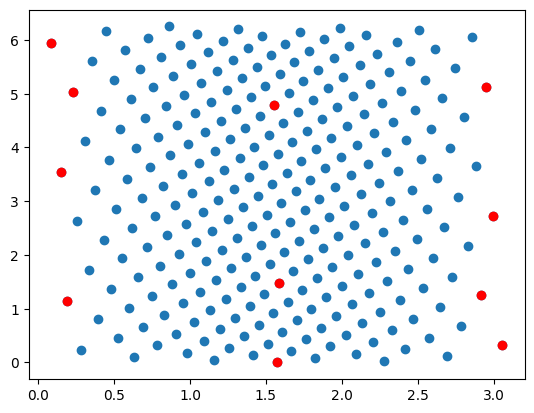

In [6]:
plt.scatter(points[:,0], points[:,1])
plt.scatter(points[mask,0], points[mask,1], c='r')


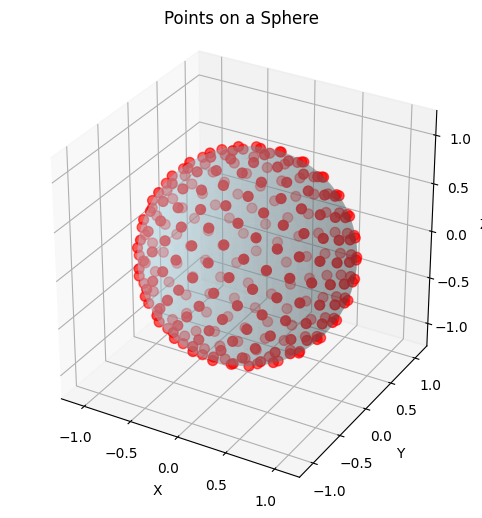

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example spherical coordinates (theta, phi) in radians
spherical_coords = points

# Separate theta and phi
theta, phi = zip(*spherical_coords)
theta = np.array(theta)
phi = np.array(phi)

# Radius of the sphere
r = 1

# Convert to Cartesian coordinates
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# Create a new figure for 3D plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create a mesh for the sphere surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
sphere_x = r * np.outer(np.cos(u), np.sin(v))
sphere_y = r * np.outer(np.sin(u), np.sin(v))
sphere_z = r * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the sphere surface
ax.plot_surface(sphere_x, sphere_y, sphere_z, color='lightblue', alpha=0.3, edgecolor='none')

# Plot the points
ax.scatter(x, y, z, color='red', s=50)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set aspect ratio to be equal
ax.set_box_aspect([1,1,1])

# Optional: Set limits
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])

# Show the plot
plt.title('Points on a Sphere')
plt.show()

In [8]:
optimizer = FibonacciOptimizer(nside, patch_size, Ninit=20, Nstepinit=10)
#N = optimizer.optimize(verbose=True)
optimizer.N_opt=273

In [9]:
# prev points
points = FibonacciHelper.fibonacci_grid_on_sphere(optimizer.N_opt)
valid_points = points[(points[:, 0] < np.pi - optimizer.radius) & (points[:, 0] > optimizer.radius)]

# additinal mask
mask_equator0 = np.sqrt((valid_points[:, 0] - np.pi/2)**2 + valid_points[:, 1]**2) <= optimizer.radius/2
mask_equator1 = np.sqrt((valid_points[:, 0] - np.pi/2)**2 + (valid_points[:, 1]-np.pi/2)**2) <= optimizer.radius/2
mask_equator2 = np.sqrt((valid_points[:, 0] - np.pi/2)**2 + (valid_points[:, 1]-np.pi)**2) <= optimizer.radius/2
mask_equator3 = np.sqrt((valid_points[:, 0] - np.pi/2)**2 + (valid_points[:, 1]-3*np.pi/2)**2) <= optimizer.radius/2

In [10]:
print(np.where(mask_equator0))
print(np.where(mask_equator1))
print(np.where(mask_equator2))
print(np.where(mask_equator3))

(array([132]),)
(array([134]),)
(array([], dtype=int64),)
(array([130]),)


In [11]:
import healpy as hp

tmp = np.zeros(hp.nside2npix(optimizer.nside))

points = FibonacciHelper.fibonacci_grid_on_sphere(optimizer.N_opt)

mask_northpole = points[:, 0] <= optimizer.radius
mask_southpole = points[:, 0] >= np.pi - optimizer.radius
mask_equator0 = np.sqrt((points[:, 0] - np.pi/2)**2 + points[:, 1]**2) <= optimizer.radius/2
mask_equator1 = np.sqrt((points[:, 0] - np.pi/2)**2 + (points[:, 1]-np.pi/2)**2) <= optimizer.radius/2
mask_equator2 = np.sqrt((points[:, 0] - np.pi/2)**2 + (points[:, 1]-np.pi)**2) <= optimizer.radius/2
mask_equator3 = np.sqrt((points[:, 0] - np.pi/2)**2 + (points[:, 1]-3*np.pi/2)**2) <= optimizer.radius/2
mask = mask_northpole | mask_southpole #| mask_equator0 | mask_equator1 | mask_equator2 | mask_equator3
invalid_points = points[mask]
valid_points = points[~mask]

# Calculate patch pixel counts for valid and invalid points
pixels = []
for center in valid_points:
    vertices = optimizer.rotated_vertices(center)
    vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])
    ipix = hp.query_polygon(nside=optimizer.nside, vertices=vecs, nest=True)
    tmp[ipix] += 1
    pixels.append(len(ipix))

for center in invalid_points:
    vertices = optimizer.rotated_vertices(center)
    vecs = hp.ang2vec(vertices[:, 0], vertices[:, 1])
    ipix = hp.query_polygon(nside=optimizer.nside, vertices=vecs, nest=True)
    tmp[ipix] -= 1
    pixels.append(len(ipix))

In [12]:
# count pixels has 1
area_covered = np.sum(tmp==1)

# count pixels has 0 or -1
area_not_covered = np.sum(tmp==0) + np.sum(tmp==-1)

percent_covered = area_covered / (area_covered + area_not_covered)

In [13]:

print(f'Percent covered: {percent_covered:.2f}')

Percent covered: 0.64


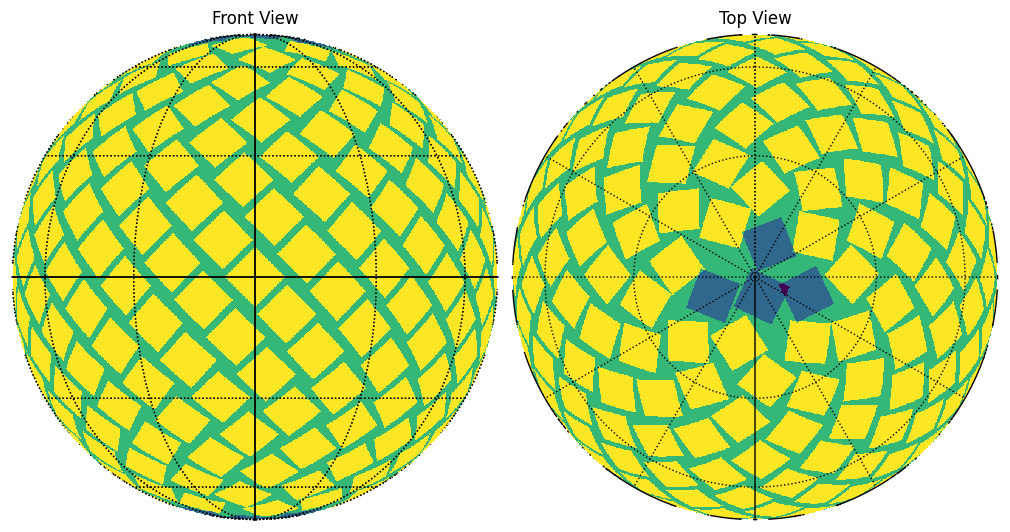

In [15]:
fig = plt.figure(figsize=(10, 5))

hp.orthview(tmp, nest=True, half_sky=True, title='Front View', sub=(1, 2, 1,), cbar=False)
hp.graticule()

hp.orthview(tmp, nest=True, half_sky=True, title='Top View', sub=(1, 2, 2), rot=(0, 90, 0), cbar=False)
hp.graticule()


In [45]:
fibonacci_grid_filename = f'{save_dir}/fibonacci_grid.png'
fig.savefig(fibonacci_grid_filename, bbox_inches='tight')
print(f'Fibonacci grid saved at {fibonacci_grid_filename}')
plt.close(fig)

Fibonacci grid saved at /lustre/work/akira.tokiwa/Projects/LensingSSC/plot/setting//fibonacci_grid.png
